Tend to redo the workflow after modifying the bug found in build_database_01.

In [1]:
import numpy as np 
import pandas as pd
import glob
import matplotlib.pyplot as plt

#plt.style.use('ggplot')
plt.style.use('seaborn-colorblind')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'

%matplotlib inline

import datetime
date = datetime.datetime.now().strftime('%Y%m%d')

# Read and build spectral datasets

## The original scans

In [11]:
core_list = glob.glob('data/SO264*')
core_list.sort()
core_list

['data/SO264-09-2',
 'data/SO264-13-2',
 'data/SO264-14-1',
 'data/SO264-15-2',
 'data/SO264-16-2',
 'data/SO264-19-2',
 'data/SO264-22-2',
 'data/SO264-24-3',
 'data/SO264-26-2',
 'data/SO264-28-2',
 'data/SO264-32-2',
 'data/SO264-34-2',
 'data/SO264-41-2',
 'data/SO264-44-2',
 'data/SO264-44-3',
 'data/SO264-45-2',
 'data/SO264-46-5',
 'data/SO264-47-2',
 'data/SO264-49-2',
 'data/SO264-51-2',
 'data/SO264-52-2',
 'data/SO264-53-2',
 'data/SO264-54-2',
 'data/SO264-55-1',
 'data/SO264-56-2',
 'data/SO264-60-12',
 'data/SO264-62-2',
 'data/SO264-64-1',
 'data/SO264-66-2',
 'data/SO264-70-1',
 'data/SO264-76-1']

In [12]:
# SO264-54-2 has a section naming the section depth 10430B
# so we deal with it later
core_list.remove('data/SO264-54-2')

In [13]:
file_name = []
spe_all = []
depth_all = []
cps_all = []
core_all = []
s_depth_all = []

# do it core by core
for core in core_list:
    i = 0
    start_depth = 0
    
    # only read the 10kV which having better signal to the light elements
    spe_dir = glob.glob('{}/Run 1 at  10kV/*.spe'.format(core))
    
    # make sure the spe directories sorted by the depth number
    spe_dir.sort()
    
    for spe in spe_dir:
        check_depth = spe.split()[3].split('_')[-1]

        # 5 and 6 digis means in mm
        # I don't use >= 5 becasue I need to make sure I'm noticed
        # if there is 7 difits or more
        if (len(check_depth) == 5) or (len(check_depth) == 6):
            check_depth = int(check_depth)
        # 3 and 4 digit means in cm, needs to be multipled to be mm
        elif len(check_depth) >= 3:
            check_depth = int(check_depth) * 10

        # this shouldn't happen, but just check
        # it did happens...
        else:
            print('Weird digits: {}'.format(spe))
                
        # if the section changes, the start depth changes
        if start_depth != check_depth:
            # reset the number for calculate composite depth
            i = 0
            start_depth = check_depth

        file_name.append(spe.split('/')[-1])
        with open(spe, 'r') as f:
            content = []
            lines = f.readlines()
            for line in lines[49:]:
                content = np.hstack((content, line.split()))

            spe_all.append(content.astype(int))
            depth_all.append(start_depth + i)
            cps_all.append(int(lines[28]))
            core_all.append(core[5:])
            s_depth_all.append(i)
            
        # the scanning resolution is 10 mm
        i += 10
    print('core {} is done.'.format(core))

core data/SO264-09-2 is done.
core data/SO264-13-2 is done.
core data/SO264-14-1 is done.
core data/SO264-15-2 is done.
core data/SO264-16-2 is done.
core data/SO264-19-2 is done.
core data/SO264-22-2 is done.
core data/SO264-24-3 is done.
core data/SO264-26-2 is done.
core data/SO264-28-2 is done.
core data/SO264-32-2 is done.
core data/SO264-34-2 is done.
core data/SO264-41-2 is done.
core data/SO264-44-2 is done.
core data/SO264-44-3 is done.
core data/SO264-45-2 is done.
core data/SO264-46-5 is done.
core data/SO264-47-2 is done.
core data/SO264-49-2 is done.
core data/SO264-51-2 is done.
core data/SO264-52-2 is done.
core data/SO264-53-2 is done.
core data/SO264-55-1 is done.
core data/SO264-56-2 is done.
core data/SO264-60-12 is done.
core data/SO264-62-2 is done.
core data/SO264-64-1 is done.
core data/SO264-66-2 is done.
core data/SO264-70-1 is done.
core data/SO264-76-1 is done.


### Deal with the SO264-54-2
SO264-54-2 is the core excluded above and has a section naming the section depth 10430B.

In [14]:
i = 0
start_depth = 0
# the rest list variables adopt the variables in the cores above

# only read the 10kV which having better signal to the light elements
spe_dir = glob.glob('data/SO264-54-2/Run 1 at  10kV/*.spe'.format(core))
# make sure the spe directories sorted by the depth number
spe_dir.sort()

for spe in spe_dir:
    check_depth = spe.split()[3].split('_')[-1]
    
    # deal with this section separately
    if check_depth == '10430B':
        start_depth = 10430
        file_name.append(spe.split('/')[-1])
        with open(spe, 'r') as f:
            content = []
            lines = f.readlines()
            for line in lines[49:]:
                content = np.hstack((content, line.split()))

            spe_all.append(content.astype(int))
            # the way calculating the composite depth is different in this section
            # the depth starts from 10.0 mm so I need to - 10 to calibrate it
            # the depth is recorded as '1000.0\n'
            depth_all.append(int(lines[13][:-3]) + start_depth - 10)
            cps_all.append(int(lines[28]))
            core_all.append('SO264-54-2')
            s_depth_all.append(int(lines[13][:-3]) - 10)
            
    else:       
        # if the section changes, the start depth changes
        if start_depth != int(check_depth):
            # reset the number for calculate composite depth
            i = 0

            # the depth are all 5 digits in this core
            start_depth = int(check_depth)

        file_name.append(spe.split('/')[-1])
        with open(spe, 'r') as f:
            content = []
            lines = f.readlines()
            for line in lines[49:]:
                content = np.hstack((content, line.split()))

            spe_all.append(content.astype(int))
            depth_all.append(start_depth + i)
            cps_all.append(int(lines[28]))
            core_all.append('SO264-54-2')
            s_depth_all.append(i)

        # the scanning resolution is 10 mm
        i += 10

In [15]:
len(spe_all)

34316

In [16]:
data_df = pd.DataFrame(spe_all, columns = [str(_) for _ in range(2048)])
data_df['cps'] = cps_all
data_df['core'] = core_all
data_df['composite_depth_mm'] = depth_all
data_df['section_depth_mm'] = s_depth_all
data_df['filename'] = file_name

In [17]:
data_df.shape

(34316, 2053)

In [9]:
data_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2043,2044,2045,2046,2047,cps,core,composite_depth_mm,section_depth_mm,file_name
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,174740,SO264-09-2,0,0,SO264-09-2_0000 10.0mm 10s 10kV 150uA No-F...
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,176896,SO264-09-2,10,10,SO264-09-2_0000 20.0mm 10s 10kV 150uA No-F...
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,183148,SO264-09-2,20,20,SO264-09-2_0000 30.0mm 10s 10kV 150uA No-F...
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,185151,SO264-09-2,30,30,SO264-09-2_0000 40.0mm 10s 10kV 150uA No-F...
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,186255,SO264-09-2,40,40,SO264-09-2_0000 50.0mm 10s 10kV 150uA No-F...


In [10]:
data_df.tail()

,0,1,2,3,4,5,6,7,8,9,...,2043,2044,2045,2046,2047,cps,core,composite_depth_mm,section_depth_mm,file_name
34311,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,110604,SO264-54-2,11380,950,SO264-54-2_10430B 960.0mm 10s 10kV 150uA No...
34312,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,117872,SO264-54-2,11390,960,SO264-54-2_10430B 970.0mm 10s 10kV 150uA No...
34313,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,120172,SO264-54-2,11400,970,SO264-54-2_10430B 980.0mm 10s 10kV 150uA No...
34314,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,122814,SO264-54-2,11410,980,SO264-54-2_10430B 990.0mm 10s 10kV 150uA No...
34315,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,74021,SO264-54-2,11420,990,SO264-54-2_10430B 1000.0mm 10s 10kV 150uA No...


## The rescan

In [20]:
core_list = glob.glob('data/SO*/Rescan*')
core_list.sort()
core_list

['data/SO264-09-2/Rescan_0269&0369',
 'data/SO264-19-2/Rescan_03400',
 'data/SO264-28-2/Rescan_05755',
 'data/SO264-28-2/Rescan_06755',
 'data/SO264-51-2/Rescan_0000&0085',
 'data/SO264-53-2/Rescan_0000&0063&0163',
 'data/SO264-55-1/Rescan_00050&01120']

In [21]:
file_name = []
spe_all = []
depth_all = []
cps_all = []
core_all = []
s_depth_all = []

# do it core by core
for core in core_list:
    i = 0
    start_depth = 0
    
    # only read the 10kV which having better signal to the light elements
    spe_dir = glob.glob('{}/Run 1 at  10kV/*.spe'.format(core))
    
    # make sure the spe directories sorted by the depth number
    spe_dir.sort()
    
    for spe in spe_dir:
        # for Rescan, it is different
        check_depth = spe.split()[3].split('/')[1].split('_')[1]

        # 5 and 6 digis means in mm
        # I don't use >= 5 becasue I need to make sure I'm noticed
        # if there is 7 difits or more
        if (len(check_depth) == 5) or (len(check_depth) == 6):
            check_depth = int(check_depth)
        # 3 and 4 digit means in cm, needs to be multipled to be mm
        elif len(check_depth) >= 3:
            check_depth = int(check_depth) * 10

        # this shouldn't happen, but just check
        # it did happens...
        else:
            print('Weird digits: {}'.format(spe))
                
        # if the section changes, the start depth changes
        if start_depth != check_depth:
            # reset the number for calculate composite depth
            i = 0
            start_depth = check_depth

        file_name.append(spe.split('/')[-1])
        with open(spe, 'r') as f:
            content = []
            lines = f.readlines()
            for line in lines[49:]:
                content = np.hstack((content, line.split()))

            spe_all.append(content.astype(int))
            depth_all.append(start_depth + i)
            cps_all.append(int(lines[28]))
            core_all.append(core.split('/')[1])
            s_depth_all.append(i)
            
        # the scanning resolution is 10 mm
        i += 10
    print('core {} is done.'.format(core))

core data/SO264-09-2/Rescan_0269&0369 is done.
core data/SO264-19-2/Rescan_03400 is done.
core data/SO264-28-2/Rescan_05755 is done.
core data/SO264-28-2/Rescan_06755 is done.
core data/SO264-51-2/Rescan_0000&0085 is done.
core data/SO264-53-2/Rescan_0000&0063&0163 is done.
core data/SO264-55-1/Rescan_00050&01120 is done.


In [22]:
rescan_df = pd.DataFrame(spe_all, columns = [str(_) for _ in range(2048)])
rescan_df['cps'] = cps_all
rescan_df['core'] = core_all
rescan_df['composite_depth_mm'] = depth_all
rescan_df['section_depth_mm'] = s_depth_all
rescan_df['filename'] = file_name

In [20]:
rescan_df.shape

(1014, 2053)

In [21]:
rescan_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2043,2044,2045,2046,2047,cps,core,composite_depth_mm,section_depth_mm,file_name
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,235339,SO264-09-2,2690,0,SO264-09-2_0269_Rescan 10.0mm 10s 10kV 150...
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,240348,SO264-09-2,2700,10,SO264-09-2_0269_Rescan 20.0mm 10s 10kV 150...
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,219589,SO264-09-2,2710,20,SO264-09-2_0269_Rescan 30.0mm 10s 10kV 150...
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,230633,SO264-09-2,2720,30,SO264-09-2_0269_Rescan 40.0mm 10s 10kV 150...
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,237169,SO264-09-2,2730,40,SO264-09-2_0269_Rescan 50.0mm 10s 10kV 150...


In [22]:
rescan_df.tail()

,0,1,2,3,4,5,6,7,8,9,...,2043,2044,2045,2046,2047,cps,core,composite_depth_mm,section_depth_mm,file_name
1009,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,93435,SO264-55-1,1980,860,SO264-55-1_01120 960.0mm 10s 10kV 150uA No-...
1010,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,93073,SO264-55-1,1990,870,SO264-55-1_01120 970.0mm 10s 10kV 150uA No-...
1011,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,92647,SO264-55-1,2000,880,SO264-55-1_01120 980.0mm 10s 10kV 150uA No-...
1012,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,91426,SO264-55-1,2010,890,SO264-55-1_01120 990.0mm 10s 10kV 150uA No-...
1013,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,69338,SO264-55-1,2020,900,SO264-55-1_01120 1000.0mm 10s 10kV 150uA No-...


In [25]:
rescan_df[(rescan_df.core == 'SO264-55-1') & (rescan_df.composite_depth_mm > 900) & (rescan_df.composite_depth_mm < 1000)]

,0,1,2,3,4,5,6,7,8,9,...,2043,2044,2045,2046,2047,cps,core,composite_depth_mm,section_depth_mm,filename
917,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,67623,SO264-55-1,910,860,SO264-55-1_00050 930.0mm 10s 10kV 150uA No-...
918,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,65647,SO264-55-1,920,870,SO264-55-1_00050 940.0mm 10s 10kV 150uA No-...
919,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,63722,SO264-55-1,930,880,SO264-55-1_00050 950.0mm 10s 10kV 150uA No-...
920,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,61688,SO264-55-1,940,890,SO264-55-1_00050 960.0mm 10s 10kV 150uA No-...
921,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,64839,SO264-55-1,950,900,SO264-55-1_00050 970.0mm 10s 10kV 150uA No-...
922,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,59254,SO264-55-1,960,910,SO264-55-1_00050 980.0mm 10s 10kV 150uA No-...


In [30]:
rescan_df[rescan_df.core == 'SO264-55-1'].to_csv('results/check.csv')

# Merge two datasets (original and rescan)
Since the section start depth of each Rescan is consistent to the original scan, I can attach the rescan data under the original data and use drop_duplicates to preserve the last element only. This way can replace the original data by the rescan data in the same section and also some overlapping scanning data by the latest data points.

In [23]:
all_df = pd.concat([data_df, rescan_df], axis = 0, join = 'inner')
all_df.shape

(35330, 2053)

In [24]:
len(data_df) + len(rescan_df)

35330

In [25]:
all_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2043,2044,2045,2046,2047,cps,core,composite_depth_mm,section_depth_mm,file_name
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,174740,SO264-09-2,0,0,SO264-09-2_0000 10.0mm 10s 10kV 150uA No-F...
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,176896,SO264-09-2,10,10,SO264-09-2_0000 20.0mm 10s 10kV 150uA No-F...
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,183148,SO264-09-2,20,20,SO264-09-2_0000 30.0mm 10s 10kV 150uA No-F...
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,185151,SO264-09-2,30,30,SO264-09-2_0000 40.0mm 10s 10kV 150uA No-F...
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,186255,SO264-09-2,40,40,SO264-09-2_0000 50.0mm 10s 10kV 150uA No-F...


## Build composite_id

In [26]:
all_df.composite_depth_mm.max()

19210

In [27]:
composite_id = []
for core, depth in zip(all_df.core, all_df.composite_depth_mm):
    composite_id.append('{}_{:05}'.format(core, depth))
    
all_df['composite_id'] = composite_id

## Drop duplicates

In [28]:
clean_df = all_df.drop_duplicates('composite_id', keep = 'last')
len(clean_df)

34375

### Check those duplicates

In [43]:
all_df.loc[all_df.composite_id.duplicated(keep = 'last'), all_df.columns[-6:]].to_csv('results/check_duplicates_1.csv')
all_df.loc[all_df.composite_id.duplicated(keep = 'last'), all_df.columns[-6:]]

,cps,core,composite_depth_mm,section_depth_mm,file_name,composite_id
268,229565,SO264-09-2,2690,0,SO264-09-2_0269 10.0mm 10s 10kV 150uA No-F...,SO264-09-2_02690
269,252567,SO264-09-2,2700,10,SO264-09-2_0269 20.0mm 10s 10kV 150uA No-F...,SO264-09-2_02700
270,235857,SO264-09-2,2710,20,SO264-09-2_0269 30.0mm 10s 10kV 150uA No-F...,SO264-09-2_02710
271,246607,SO264-09-2,2720,30,SO264-09-2_0269 40.0mm 10s 10kV 150uA No-F...,SO264-09-2_02720
272,240093,SO264-09-2,2730,40,SO264-09-2_0269 50.0mm 10s 10kV 150uA No-F...,SO264-09-2_02730
...,...,...,...,...,...,...
33109,64206,SO264-76-1,3250,990,SO264-76-1_0226 1160.0mm 10s 10kV 150uA No-F...,SO264-76-1_03250
33253,73206,SO264-54-2,430,430,SO264-54-2_00000 510.0mm 10s 10kV 150uA No-...,SO264-54-2_00430
628,19888,SO264-53-2,630,630,SO264-53-2_0000 640.0mm 10s 10kV 150uA No-F...,SO264-53-2_00630
629,19318,SO264-53-2,640,640,SO264-53-2_0000 650.0mm 10s 10kV 150uA No-F...,SO264-53-2_00640


In [40]:
np.unique(all_df.loc[all_df.composite_id.duplicated(keep = 'last'), 'core'], return_counts = True)

(array(['SO264-09-2', 'SO264-13-2', 'SO264-14-1', 'SO264-15-2',
        'SO264-19-2', 'SO264-22-2', 'SO264-26-2', 'SO264-28-2',
        'SO264-41-2', 'SO264-51-2', 'SO264-53-2', 'SO264-54-2',
        'SO264-55-1', 'SO264-64-1', 'SO264-66-2', 'SO264-76-1'],
       dtype=object),
 array([200,   2,   1, 102,   9,  11,   3, 180,   1, 175, 260,   1,   2,
          1,   1,   6]))

The cores having more than 100 data pooints are weird. Let' check.

In [44]:
core_list

['data/SO264-09-2/Rescan_0269&0369',
 'data/SO264-19-2/Rescan_03400',
 'data/SO264-28-2/Rescan_05755',
 'data/SO264-28-2/Rescan_06755',
 'data/SO264-51-2/Rescan_0000&0085',
 'data/SO264-53-2/Rescan_0000&0063&0163',
 'data/SO264-55-1/Rescan_00050&01120']

Let's check those cores having more than 100 data points being duplicates.<br>
SO264-09-2, SO264-28-2, SO264-51-2, SO264-53-2: rescaned <br>
SO264-15-2: there are 0048 spe and 048 spe in the original folder, I reckon it's a rescan but not mentioned.

In [ ]:
clean_df = clean_df.set_index('composite_id')

In [57]:
# I prefer "filename", which is consistent to Itrax's format
clean_df['filename'] = clean_df.file_name
clean_df.drop('file_name', axis = 1, inplace = True)
clean_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2043,2044,2045,2046,2047,cps,core,composite_depth_mm,section_depth_mm,filename
composite_id,,,,,,,,,,,,,,,,,,,,,
SO264-09-2_00000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,174740,SO264-09-2,0,0,SO264-09-2_0000 10.0mm 10s 10kV 150uA No-F...
SO264-09-2_00010,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,176896,SO264-09-2,10,10,SO264-09-2_0000 20.0mm 10s 10kV 150uA No-F...
SO264-09-2_00020,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,183148,SO264-09-2,20,20,SO264-09-2_0000 30.0mm 10s 10kV 150uA No-F...
SO264-09-2_00030,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,185151,SO264-09-2,30,30,SO264-09-2_0000 40.0mm 10s 10kV 150uA No-F...
SO264-09-2_00040,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,186255,SO264-09-2,40,40,SO264-09-2_0000 50.0mm 10s 10kV 150uA No-F...


In [58]:
clean_df[clean_df.filename.duplicated()]

,0,1,2,3,4,5,6,7,8,9,...,2043,2044,2045,2046,2047,cps,core,composite_depth_mm,section_depth_mm,filename
composite_id,,,,,,,,,,,,,,,,,,,,,


## Check nan

In [61]:
clean_df.isnull().values.any()

False

## Build section

In [2]:
clean_df = pd.read_csv('data/spe_dataset_20201007.csv', index_col = 0)

In [3]:
clean_df[clean_df.section_depth_mm == 0]

,0,1,2,3,4,5,6,7,8,9,...,2043,2044,2045,2046,2047,cps,core,composite_depth_mm,section_depth_mm,filename
composite_id,,,,,,,,,,,,,,,,,,,,,
SO264-09-2_00000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,174740,SO264-09-2,0,0,SO264-09-2_0000 10.0mm 10s 10kV 150uA No-F...
SO264-09-2_00700,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,193580,SO264-09-2,700,0,SO264-09-2_0070 10.0mm 10s 10kV 150uA No-F...
SO264-09-2_01690,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,213786,SO264-09-2,1690,0,SO264-09-2_0169 10.0mm 10s 10kV 150uA No-F...
SO264-09-2_04690,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,224499,SO264-09-2,4690,0,SO264-09-2_0469 10.0mm 10s 10kV 150uA No-F...
SO264-09-2_05690,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,199690,SO264-09-2,5690,0,SO264-09-2_0569 10.0mm 10s 10kV 150uA No-F...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SO264-53-2_00000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,86433,SO264-53-2,0,0,SO264-53-2_0000 10.0mm 10s 10kV 150uA No-F...
SO264-53-2_00630,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,104956,SO264-53-2,630,0,SO264-53-2_0063 10.0mm 10s 10kV 150uA No-F...
SO264-53-2_01630,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,104151,SO264-53-2,1630,0,SO264-53-2_0163 10.0mm 10s 10kV 150uA No-F...


In [67]:
clean_df.sort_values(by = 'composite_id', axis = 0, inplace = True)
clean_df

,0,1,2,3,4,5,6,7,8,9,...,2043,2044,2045,2046,2047,cps,core,composite_depth_mm,section_depth_mm,filename
composite_id,,,,,,,,,,,,,,,,,,,,,
SO264-09-2_00000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,174740,SO264-09-2,0,0,SO264-09-2_0000 10.0mm 10s 10kV 150uA No-F...
SO264-09-2_00010,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,176896,SO264-09-2,10,10,SO264-09-2_0000 20.0mm 10s 10kV 150uA No-F...
SO264-09-2_00020,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,183148,SO264-09-2,20,20,SO264-09-2_0000 30.0mm 10s 10kV 150uA No-F...
SO264-09-2_00030,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,185151,SO264-09-2,30,30,SO264-09-2_0000 40.0mm 10s 10kV 150uA No-F...
SO264-09-2_00040,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,186255,SO264-09-2,40,40,SO264-09-2_0000 50.0mm 10s 10kV 150uA No-F...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SO264-76-1_04200,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,58656,SO264-76-1,4200,950,SO264-76-1_0325 1120.0mm 10s 10kV 150uA No-F...
SO264-76-1_04210,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,54854,SO264-76-1,4210,960,SO264-76-1_0325 1130.0mm 10s 10kV 150uA No-F...
SO264-76-1_04220,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,57354,SO264-76-1,4220,970,SO264-76-1_0325 1140.0mm 10s 10kV 150uA No-F...


In [4]:
section_all = []
# make sure the order follows the core and composite depth
clean_df.sort_values(by = 'composite_id', axis = 0, inplace = True)

for core in np.unique(clean_df.core):    
    # I assume every core scanned from 0 mm so the first section in the core is marked as section 0
    # the deeper the larger number
    section = -1
    X = clean_df[clean_df.core == core]
    for index, row in X.iterrows():
        if row.section_depth_mm == 0:
            section += 1
        section_all.append(section)
clean_df['section'] = section_all

In [5]:
clean_df

,0,1,2,3,4,5,6,7,8,9,...,2044,2045,2046,2047,cps,core,composite_depth_mm,section_depth_mm,filename,section
composite_id,,,,,,,,,,,,,,,,,,,,,
SO264-09-2_00000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,174740,SO264-09-2,0,0,SO264-09-2_0000 10.0mm 10s 10kV 150uA No-F...,0
SO264-09-2_00010,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,176896,SO264-09-2,10,10,SO264-09-2_0000 20.0mm 10s 10kV 150uA No-F...,0
SO264-09-2_00020,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,183148,SO264-09-2,20,20,SO264-09-2_0000 30.0mm 10s 10kV 150uA No-F...,0
SO264-09-2_00030,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,185151,SO264-09-2,30,30,SO264-09-2_0000 40.0mm 10s 10kV 150uA No-F...,0
SO264-09-2_00040,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,186255,SO264-09-2,40,40,SO264-09-2_0000 50.0mm 10s 10kV 150uA No-F...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SO264-76-1_04200,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,58656,SO264-76-1,4200,950,SO264-76-1_0325 1120.0mm 10s 10kV 150uA No-F...,4
SO264-76-1_04210,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,54854,SO264-76-1,4210,960,SO264-76-1_0325 1130.0mm 10s 10kV 150uA No-F...,4
SO264-76-1_04220,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,57354,SO264-76-1,4220,970,SO264-76-1_0325 1140.0mm 10s 10kV 150uA No-F...,4


In [6]:
np.argmax(clean_df.iloc[:, :2048].mean())

185

/home/users/aslee/miniconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='composite_id'>

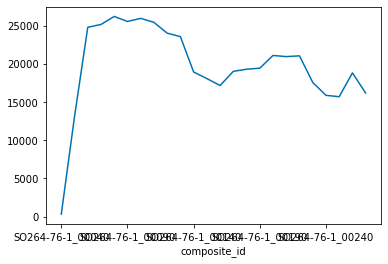

In [90]:
clean_df.loc[(clean_df.core == 'SO264-76-1') & (clean_df.section == 0), '185'].plot()

I don't have any idea to test if section numbers are all right yet...

# Export dataset

In [7]:
clean_df.to_csv('data/spe_dataset_{}.csv'.format(date))